# Predict Fuel Efficiency of a Vehicle
We will build a regression model that can predict a vehicle's fuel efficiency in mpg.

The dataset used to build the model was downloaded from [UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/Auto+MPG).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio


In [2]:
plt.style.use('seaborn-darkgrid')
sns.set_style('darkgrid')

In [3]:
pio.renderers.default = 'notebook_connected'

In [4]:
column_names = ['mpg', 'cylinders', 'displacement', 'horsepower',
                'weight', 'acceleration', 'model year', 'origin', 'car name']
df_vehicles = pd.read_csv('./data/auto-mpg.csv',
                          delim_whitespace=True,
                          names=column_names)
df_vehicles.head()


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


The descriptions for each feature are as follows:

* mpg: miles per gallon.
* cylinders: number of cylinders. **(categorical)**
* displacement: engine displacement (cubic inches).
* horsepower.
* weight: vehicle weight (lbs).
* acceleration: time to accelerate from O to 60 mph (sec).
* model year (modulo 100). **(categorical)**
* origin: origin of car (1. American, 2. European, 3. Japanese). **(categorical)**
* and the car name.

In [5]:
df_vehicles.shape

(398, 9)

In [6]:
df_vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


In [7]:
df_vehicles.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

There is no `na` values at all. But notice the dtype of the **horsepower** column is object not float. Let's take a look:

In [8]:
df_vehicles['horsepower'].unique()

array(['130.0', '165.0', '150.0', '140.0', '198.0', '220.0', '215.0',
       '225.0', '190.0', '170.0', '160.0', '95.00', '97.00', '85.00',
       '88.00', '46.00', '87.00', '90.00', '113.0', '200.0', '210.0',
       '193.0', '?', '100.0', '105.0', '175.0', '153.0', '180.0', '110.0',
       '72.00', '86.00', '70.00', '76.00', '65.00', '69.00', '60.00',
       '80.00', '54.00', '208.0', '155.0', '112.0', '92.00', '145.0',
       '137.0', '158.0', '167.0', '94.00', '107.0', '230.0', '49.00',
       '75.00', '91.00', '122.0', '67.00', '83.00', '78.00', '52.00',
       '61.00', '93.00', '148.0', '129.0', '96.00', '71.00', '98.00',
       '115.0', '53.00', '81.00', '79.00', '120.0', '152.0', '102.0',
       '108.0', '68.00', '58.00', '149.0', '89.00', '63.00', '48.00',
       '66.00', '139.0', '103.0', '125.0', '133.0', '138.0', '135.0',
       '142.0', '77.00', '62.00', '132.0', '84.00', '64.00', '74.00',
       '116.0', '82.00'], dtype=object)

We can see that there is a `?` placeholder for missing values.

In [9]:
df_vehicles[df_vehicles['horsepower'] == '?']

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
32,25.0,4,98.0,?,2046.0,19.0,71,1,ford pinto
126,21.0,6,200.0,?,2875.0,17.0,74,1,ford maverick
330,40.9,4,85.0,?,1835.0,17.3,80,2,renault lecar deluxe
336,23.6,4,140.0,?,2905.0,14.3,80,1,ford mustang cobra
354,34.5,4,100.0,?,2320.0,15.8,81,2,renault 18i
374,23.0,4,151.0,?,3035.0,20.5,82,1,amc concord dl


There are 6 entries that have `?` as a placeholder for missing values. I don't want to drop those rows, I want to replace them with `nan` values and then I can decide to fill them with mean or median.

In [10]:
df_vehicles['horsepower'] = df_vehicles['horsepower'].replace('?', np.nan, regex=False)

In [11]:
print('?' in df_vehicles['horsepower'])

False


Ok so now that we have replace the `?` with `nan`. Let's check the dtype again:

In [12]:
df_vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    object 
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


It's still an object dtype column. That's because when we imported the dataset using `pd.read_csv`, pandas coerced the column as object. We have to manually change its dtype to numeric.

In [13]:
df_vehicles['horsepower'] = pd.to_numeric(df_vehicles['horsepower'])
df_vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB


That's good. Now I want to see the statistics of the entire DataFrame.

In [14]:
df_vehicles.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [15]:
fig = px.histogram(
    data_frame=df_vehicles,
    x='horsepower',
    marginal='box',
    labels={'horsepower': 'Horsepower'}
)

fig.show()

I decided to replace the `nan` values with the median since adding more median values does not change much the distribution histogram.

In [16]:
median_power = df_vehicles['horsepower'].median()
df_vehicles['horsepower'] = df_vehicles['horsepower'].fillna(median_power)
df_vehicles.isna().any()

mpg             False
cylinders       False
displacement    False
horsepower      False
weight          False
acceleration    False
model year      False
origin          False
car name        False
dtype: bool

Good, we have replaced the `nan` with the median. Now let's look at the categorical columns.

First of all, let's see the counts of each unique values in those columns:

In [17]:
categorical_columns = ['cylinders', 'model year', 'origin']

for col in categorical_columns:
    print(f'Value counts of "{df_vehicles[col].name}" column:\n{df_vehicles[col].value_counts()}')
    print()

Value counts of "cylinders" column:
4    204
8    103
6     84
3      4
5      3
Name: cylinders, dtype: int64

Value counts of "model year" column:
73    40
78    36
76    34
82    31
75    30
70    29
79    29
80    29
81    29
71    28
72    28
77    28
74    27
Name: model year, dtype: int64

Value counts of "origin" column:
1    249
3     79
2     70
Name: origin, dtype: int64



I probably want to replace the `1, 2, 3` values with `American, European, Japanese` in the `origin` column for better visualization. Then turn the dtype of `cylinders`, `model year` and `origin` into categorical dtype.

In [18]:
# replace [1, 2, 3] with ['American', 'European', 'Japanese']
df_vehicles['origin'] = df_vehicles['origin'].replace(to_replace=[1, 2, 3], value=['American', 'European', 'Japanese'])

# convert dtype to 'category'
df_vehicles['cylinders'] = df_vehicles['cylinders'].astype('category')
df_vehicles['model year'] = df_vehicles['model year'].astype('category')
df_vehicles['origin'] = df_vehicles['origin'].astype('category')


Now I want to create a boxplot to see how each categorical column affects a vehicle's performance.

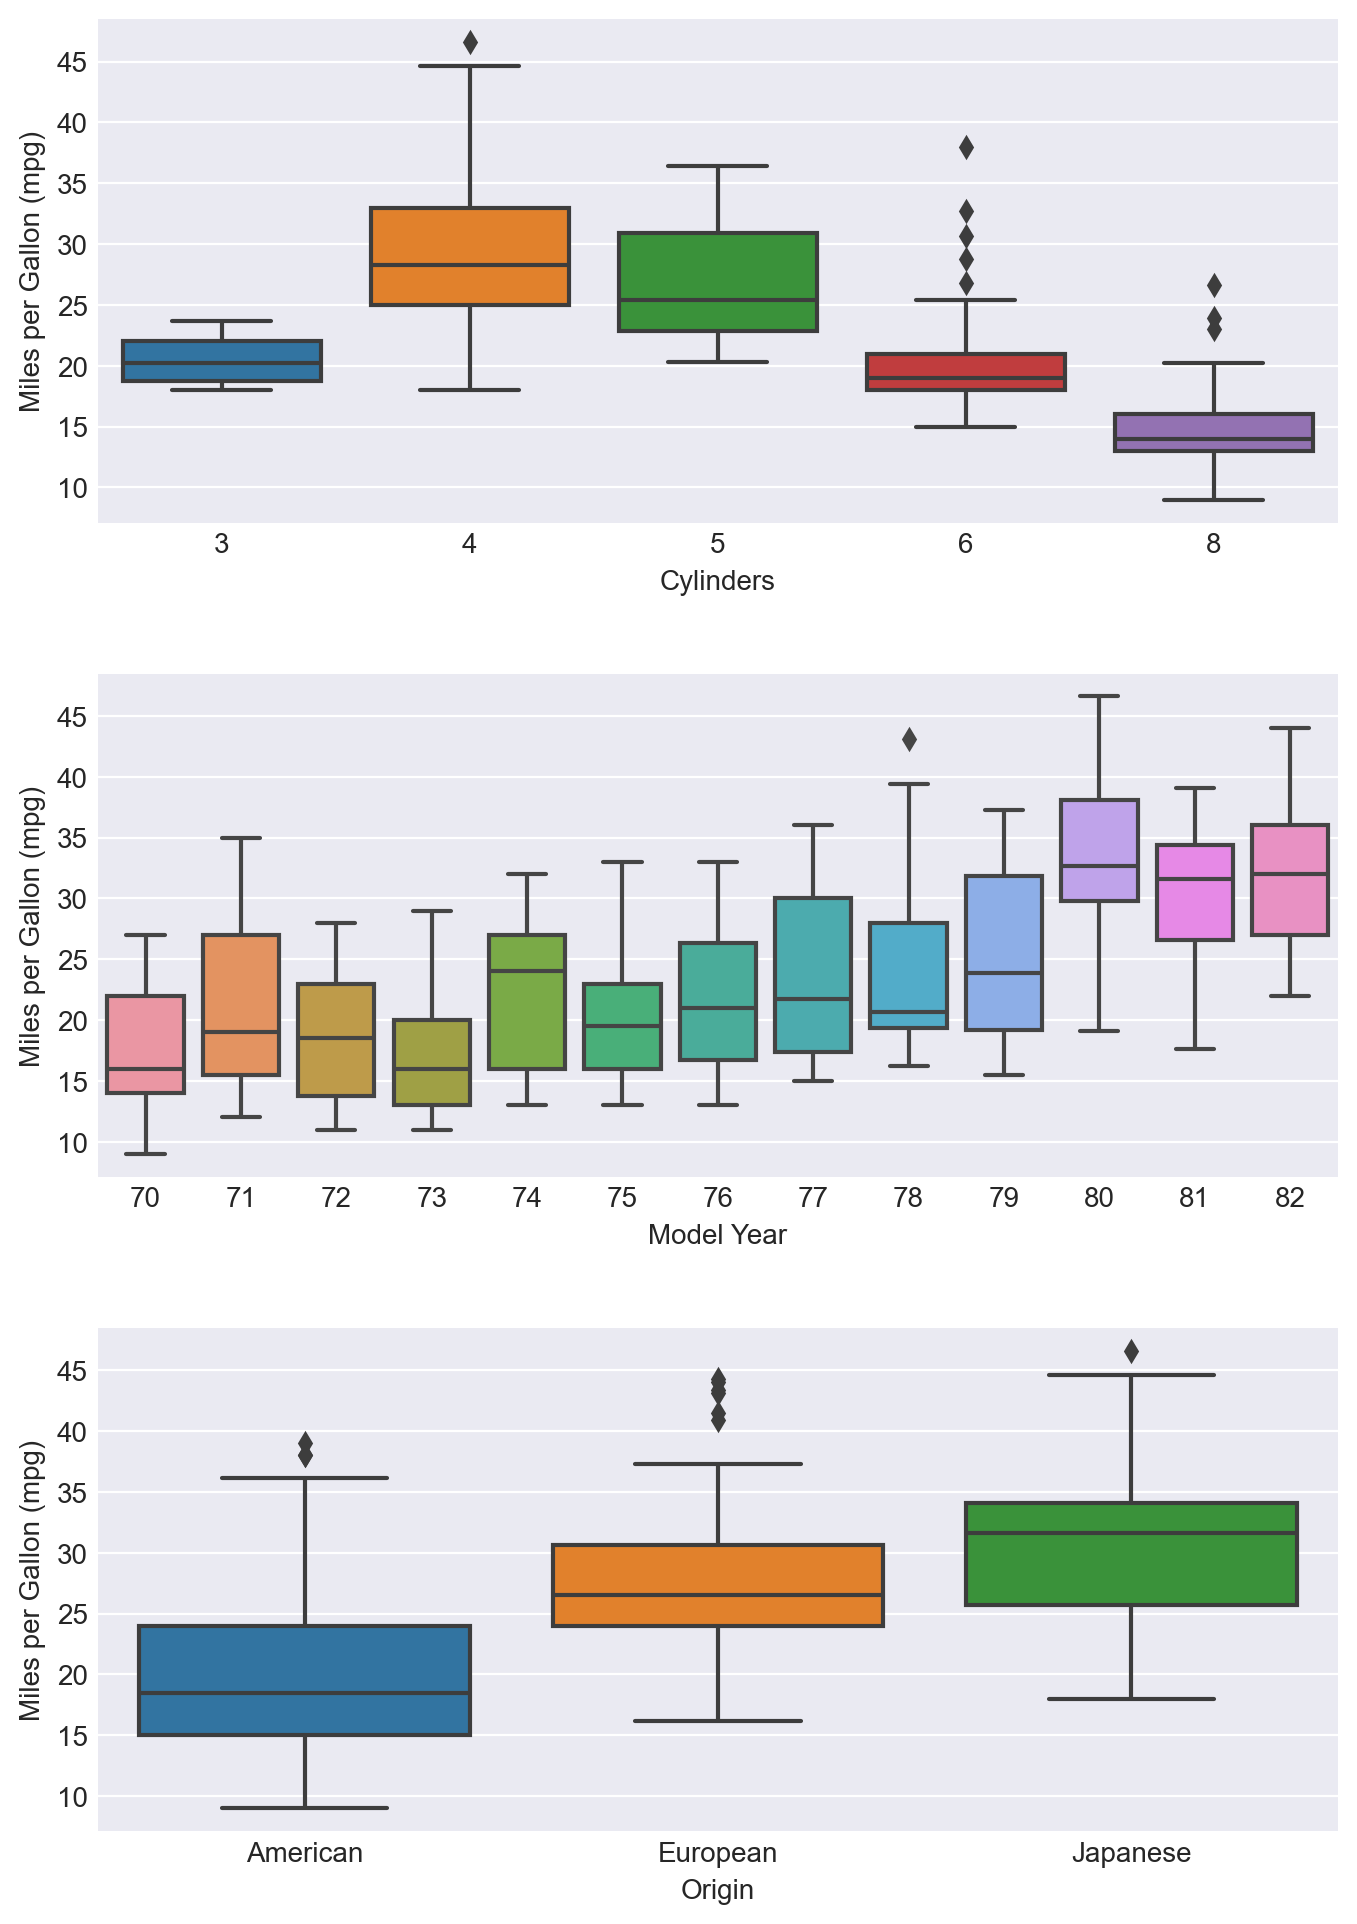

In [19]:
fig, axes = plt.subplots(figsize=(8, 12), dpi=200,
                         nrows=3, ncols=1, gridspec_kw={'hspace': 0.3})

for i, col in enumerate(categorical_columns):
    sns.boxplot(x=col, y='mpg', data=df_vehicles, ax=axes[i])
    axes[i].set_ylabel('Miles per Gallon (mpg)', fontsize=10)
    axes[i].set_xlabel(col.title(), fontsize=10)

plt.show()


From the above plot, it looks like cars with 4 cylinders generally achive higher mileage. For the `model year` column, the later the year when the car was produced, the better the performance.

Last but not least, overall, Japanese cars seem to be more fuel efficient.